Spencer Halverson
MATH 437
12/9/2021

In [1]:
import scipy as sp
from scipy.sparse import spdiags
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve_banded
import numpy as np
import matplotlib.pyplot as plt

# Problem 1

Use the finite element method to solve
 
εy" − y' = −1,

y(0) = α, y(1) = β,


where α = 2, β = 4, and ε = 0.02. Use N = 100 finite elements (101 grid points). Compare
your solution with the analytic solution

y(x) = α + x + (β − α − 1)* (e^(x/ε) − 1)/(e^(1/ε) − 1) by graphing.


In [2]:
# this code is necessary for the banded solver
def diagonal_form(a, lower= 1, upper = 1):
    """
    a is a numpy square matrix
    this function converts a square matrix to diagonal ordered form
    returned matrix in ab shape which can be used directly for scipy.linalg.solve_banded
    """
    n = a.shape[1]
    assert(np.all(a.shape ==(n,n)))
    
    ab = np.zeros((2*n-1, n))
    
    for i in range(n):
        ab[i,(n-1)-i:] = np.diagonal(a,(n-1)-i)
        
    for i in range(n-1): 
        ab[(2*n-2)-i,:i+1] = np.diagonal(a,i-(n-1))

    mid_row_inx = int(ab.shape[0]/2)
    upper_rows = [mid_row_inx - i for i in range(1, upper+1)]
    upper_rows.reverse()
    upper_rows.append(mid_row_inx)
    lower_rows = [mid_row_inx + i for i in range(1, lower+1)]
    keep_rows = upper_rows+lower_rows
    ab = ab[keep_rows,:]

    return ab


# a = np.array([[1,0,2,0,0],
#               [2,3,3,3,0],
#               [0,2,3,4,7],
#               [0,0,1,4,3],
#               [0,0,0,0,1]])

# print(diagonal_form(a,upper=2,lower=1))


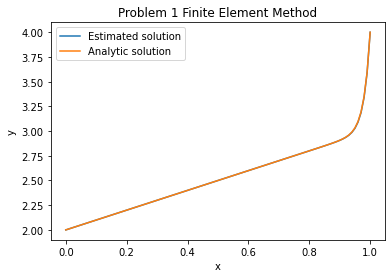

In [3]:
def solve_finite_method(alpha=2, beta=4, eps=0.02, x_vals=np.linspace(0,1,101)):
    """Solve the differential equation eps*y" - y' = -1.
    Takes boundary conditions alpha and beta,
    parameter epsilon, number of points N, and 
    a list of spaced points in an interval.
    Note that there must be N+1 points total.
    """
    
    N = len(x_vals) - 1

    h = x_vals[1:]-x_vals[:-1]

    # define functions to solve matrix
    def a(i, j):
        if j == i + 1:
            return eps/h[i] + 1./2
        elif j == i:
            return -1*eps/h[i-1] - eps/h[i]
        elif j == i-1:
            return eps/h[i-1] - 1./2
        else:
            return 0.

    def l(j):
        return -(1./2)*(h[j-1]+h[j])

    def phi(i, x):
        if i == 0:
            if x>x_vals[1]:
                return 0
            else:
                return (x_vals[1] - x)/h[0]
        if i == N:
            if x < x_vals[-2]:
                return 0
            else:
                return (x - x_vals[-2])/h[-1]
        if x >= x_vals[i-1] and x <= x_vals[i]:
            return (x-x_vals[i-1])/h[i-1]
        elif x>= x_vals[i] and x <= x_vals[i+1]:
            return (x_vals[i+1]-x)/h[i]
        else:
            return 0

    # define A and Phi
    A = 1.0*np.zeros((N+1, N+1))
    A[0,0] = 1.
    A[-1, -1] = 1.
    for j in range(1,N):
        A[j][j-1] = a(j-1, j)
        A[j][j] = a(j,j)
        A[j][j+1] = a(j+1, j)

    Phi = np.array([alpha] + [l(j) for j in range(1, N)] + [beta])

    # transform and solve A@K = Phi
    A_banded = diagonal_form(A, lower=1, upper=1)
    K = solve_banded((1,1), A_banded, Phi)

    # generate function y
    def y_generator(K):
        fun = np.vectorize(lambda x: np.sum([K[i]*phi(i, x) for i in range(N+1)]))
        return fun 

    y_hat = y_generator(K)
    
    return y_hat(x_vals)

x_list = np.linspace(0,1,101)
y_hat = solve_finite_method()
alpha = 2
beta = 4
eps = 0.02
y_analytic = np.vectorize(lambda x: 2+x+(beta-alpha-1)*(np.exp(x/eps) - 1)/(np.exp(1/eps) - 1))

# plot estimated solution against analytic solution
plt.plot(x_list, y_hat, label="Estimated solution")
plt.plot(x_list, y_analytic(x_list), label="Analytic solution")
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Problem 1 Finite Element Method")
plt.show()






# Problem 2

Compare the numerical solution when the grid points are unevenly spaced versus when the grid points
are clustered in the area of greatest change by plotting.

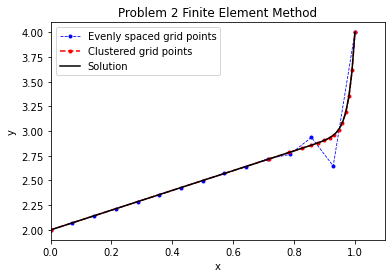

In [4]:
# set 3 different linspaces of points
x_list = np.linspace(0,1,101)
even_grid = np.linspace(0,1,15)
clustered_grid = np.linspace(0, 1, 15)**(1./8)

# find solutions
y_hat_even = solve_finite_method(x_vals=even_grid)
y_hat_clustered = solve_finite_method(x_vals=clustered_grid)
y_analytic = np.vectorize(lambda x: alpha+x+(beta-alpha-1)*(np.exp(x/eps) - 1)/(np.exp(1/eps) - 1))

# plot solutions
plt.plot(even_grid, y_hat_even, 'b.--', linewidth=0.8, label="Evenly spaced grid points")
plt.plot(clustered_grid, y_hat_clustered, 'r.--', label="Clustered grid points")
plt.plot(x_list, y_analytic(x_list), 'k', label="Solution")
plt.xlim(0, 1.1)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Problem 2 Finite Element Method")
plt.show()

# Problem 3

Solve (11.5) with the finite element method using N = 2^i finite elements, i = 4, 5, . . . , 21.

Use a log-log plot to graph the error.

In [5]:
# find true solution
top = 14
x_list = np.linspace(0,1,(2**top) + 1)
y_analytic = np.vectorize(lambda x: alpha+x+(beta-alpha-1)*(np.exp(x/eps) - 1)/(np.exp(1/eps) - 1))
true_vals = y_analytic(x_list)

# solve for approximation and compute error
errors = []
for i in range(4, top+1):
    points = np.linspace(0, 1, (2**i) + 1)
    y_hat = solve_finite_method(x_vals=points)
    select = true_vals[::2**(top-i)]
    errors.append(np.linalg.norm(y_hat-select))


# plot error
plt.loglog(2**np.arange(4,top+1), errors)
plt.xlabel('n')
plt.ylabel('E(n)')
plt.title("Problem 3 Error Graph")
plt.show()

i = 21 was taking way too long so I shortened it to 14.